In [29]:
%%capture
#%matplotlib inline
%matplotlib notebook

%load_ext autoreload
%autoreload 2

%reset -f

import os
import numpy as np

In [30]:
import pylab as plt
plt.rcParams.update({"axes.grid" : True})

In [31]:
from dartwarslab.base import file2dic, dic2file

In [32]:
(start, stop) = (25,35)
Lks_target = np.linspace(start=start, stop=stop, num=stop-start+1)

In [33]:
def dump(Ztarget, Z, l, L, C, w, Lk, islabel=True):
    labels = ['Z0target', 'Z0' ,   'l'   , 'L'   , 'C'   , 'Lk',      'nsq', 'Lf', 'Cf']
    units  = ['[Ohm]'   , '[Ohm]', '[um]', '[pH]', '[fF]', '[pH/sq]', ''   , 'nH', '[fF]'] 
    
    nsq = l/w     # number of square per finger
    Lf  = Lk*nsq  # finger inductance to ground (Malnou's model)
    Cf  = C/2     # finger capacitance to ground (Malnou's model)
    
    formatter=''.join(['%-12s']*len(labels))
    
    restarget=[a*b for a,b in zip([Ztarget, Z, l ,L, C, Lk, nsq, Lf, Cf], 
                                  [1, 1, 1, 1e12, 1e15, 1e12, 1, 1e9, 1e15])]
    

    if islabel:
        print (formatter%tuple(labels))
        print (formatter%tuple(units))
        print('-' * 110)
    print (formatter%tuple(["%.2f" % i for i in restarget]))
        
    return

In [34]:
ZOfun = lambda L, C : np.sqrt(L/C)

In [35]:
def create_path(Lks_target, e, d, basepath):
    
    (newLks, files) = (list(), list())
    
    
    for Lk in Lks_target:
        filepath = os.path.join(basepath,'eps{e}_d{d}'.format(e=e, d=d))
        filepath = os.path.join(filepath,'sim-results', 'sim_eps{e:.1f}_Lk{Lk:.1f}'.format(e=e, Lk=Lk), 'savepath')
        if os.path.isdir(filepath):
            files.append(os.path.join(filepath, [d for d in os.listdir(filepath) if 'reduced' in d][0]))
            newLks.append(Lk)
    
    return newLks, files

In [36]:
def get_colors(inp, colormap, vmin=None, vmax=None):
    norm = plt.Normalize(vmin, vmax)
    return colormap(norm(inp))

In [37]:
from matplotlib import cm, colors
cmap   = plt.cm.turbo_r
cols   = get_colors(Lks_target, cmap, 
                    vmin=np.min(Lks_target), vmax=np.max(Lks_target))
cols   = dict(zip(reversed(Lks_target), cols))

In [38]:
basepath='/home/giachero/gsbox/kids_rd/DARTWARS/sonnet-sim/IMS-NIST/general'

<IPython.core.display.Javascript object>


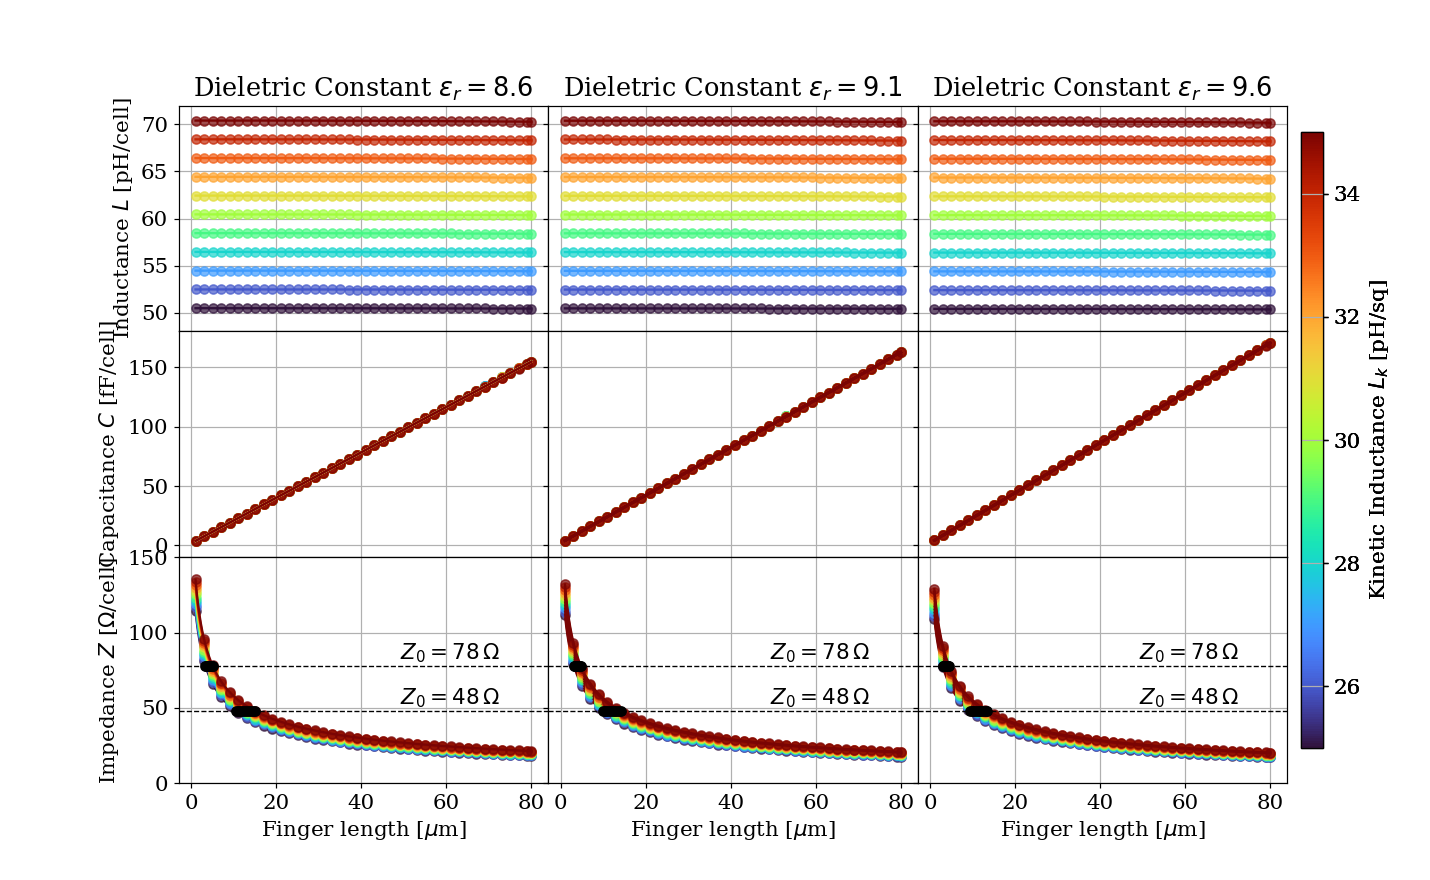

In [39]:
d   = 100
eps = [8.6, 9.1, 9.6]

data=dict()

figs=list()

fig, ax = plt.subplots(3,3, figsize=(13, 8))
figs.append(fig)
plt.subplots_adjust(wspace=0, hspace=0)

for e, i in zip(eps, [0,1,2]):
    
    newLks, fpath = create_path(Lks_target, e, d=d, basepath=basepath)
    
    files = dict(zip(newLks, fpath))

    data.setdefault(e, {})
    
    data[e] = {Lk: file2dic(files[Lk], writer='h5').read() for Lk in files}   

    for Lk in data[e]:
        data[e][Lk].update({'Z'   : ZOfun(data[e][Lk]['L'],   data[e][Lk]['C']),                                                                 
                            'Zfit': ZOfun(data[e][Lk]['Lfit'],data[e][Lk]['Cfit'])})
    
    #fig.set_size_inches(8, 10, forward=True)


    for Lk in data[e]:
        ax[0,i].plot(data[e][Lk]['l'],    data[e][Lk]['L']*1e12, marker = 'o', ls='none', 
                   alpha=0.7, color=cols[Lk])
        ax[0,i].plot(data[e][Lk]['lfit'], data[e][Lk]['Lfit']*1e12, marker = 'none', ls='-',
                   #label='$L_k={Lk}$ pH/sq'.format(Lk=Lk),
                   color=ax[0,i].lines[-1].get_color())
        
        ax[0,i].set_title('Dieletric Constant $\\varepsilon_r={e}$'.format(e=e))
        #ax[0,i].set_xlabel('Finger length [$\\mu$m]')

        ax[0,i].set_ylim([48, 72])
        ax[0,i].tick_params('x', labelbottom=False)
        
        if not i:
            ax[0,i].set_ylabel('Inductance $L$ [pH/cell]')
        
        if i:
            ax[0,i].tick_params('y', labelleft=False)
        #ax[0,i].set_yticklabels([])
        
        #ax[0].legend(loc="lower left")

        ax[1,i].plot(data[e][Lk]['l'],    data[e][Lk]['C']*1e15, marker = 'o', ls='none', 
                   alpha=0.7, color=cols[Lk])
        ax[1,i].plot(data[e][Lk]['lfit'], data[e][Lk]['Cfit']*1e15, marker = 'none', ls='-', 
                   label='$L_k={Lk}$ pH/sq'.format(Lk=Lk),
                   color=ax[1,0].lines[-1].get_color(), zorder=1000)
        #ax[1,i].set_xlabel('Finger length [$\\mu$m]')
        ax[1,i].set_ylim([-10, 180])
        ax[1,i].tick_params('x', labelbottom=False)
        
        if not i:
            ax[1,i].set_ylabel('Capacitance $C$ [fF/cell]')
        
        if i:
            ax[1,i].tick_params('y', labelleft=False)
        
    
        ax[2,i].plot(data[e][Lk]['l'],    data[e][Lk]['Z'], marker = 'o', ls='none', 
                   alpha=0.7, color=cols[Lk])
        ax[2,i].plot(data[e][Lk]['lfit'], data[e][Lk]['Zfit'], marker = 'none', ls='-', 
                   label='$L_k={Lk}$ pH/sq'.format(Lk=Lk),
                   #label='$L_k={Lk}$ pH/sq'.format(Lk=Lk),
                   color=ax[2,0].lines[-1].get_color())
        ax[2,i].set_xlabel('Finger length [$\\mu$m]')
        #ax[2].legend(loc="upper right")
        ax[2,i].set_ylim([0, 150])

        if not i:
            ax[2,i].set_ylabel('Impedance $Z$ [$\\Omega$/cell]')
  
        if i:
            ax[2,i].tick_params('y', labelleft=False)
 
    #ax[2].legend(loc='center left', bbox_to_anchor=(0.65, 1.0))
    
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.91, 0.15, 0.015, 0.7])
    fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(np.min(Lks_target),                                                 
                                                         np.max(Lks_target)), cmap=cmap.reversed()), 
                 ax=ax[1,0], cax=cbar_ax)
    
    cbar_ax.set_ylabel('Kinetic Inductance $L_k$ [pH/sq]')
    #cbar_ax.invert_yaxis()

In [40]:
Zarget = [78, 48]
for i in [0,1,2]:
    for Z0target in Zarget:
        ax[2,i].axhline(y=Z0target, color='black', lw=0.9, ls='--')
        xtext=ax[2,i].get_xlim()[1]-0.40*(ax[2,i].get_xlim()[1]-ax[2,i].get_xlim()[0])
        ax[2,i].text(xtext, Z0target+4, r'$Z_0 = {Z}\,\Omega$'.format(Z=Z0target))

In [41]:
resdict=dict()
for e in data:
    resdict.setdefault(e,{})
    resdict[e].update({Z: {'l': list(), 'Lk': list(), 'Zfit': list()}  for Z in Zarget })    
    for Lk in data[e]: 
        for Z in Zarget:
            resdict[e][Z]['Lk'].append(Lk)  
            idx=np.argmin(np.abs(Z-data[e][Lk]['Zfit']))
            resdict[e][Z]['Zfit'].append(data[e][Lk]['Zfit'][idx])
            resdict[e][Z]['l'].append(data[e][Lk]['lfit'][idx])

In [42]:
for e, i in zip(resdict, [0,1,2]):
    for Z in resdict[e]:
        ax[2,i].plot(resdict[e][Z]['l'], 
                     resdict[e][Z]['Zfit'], 
                     marker='o', ls='none', color='k', zorder=100)

In [43]:
saveplot = os.path.join(basepath, 'saveplot')
os.makedirs(saveplot) if not os.path.exists(saveplot) else None
    
for e in ['.pdf', '.svg']:
    plt.gcf().savefig(os.path.join(saveplot,'global_trend_vs_eps'+e),
                      bbox_inches='tight', transparent=True)

In [52]:
np.save(os.path.join(saveplot,'global_trend.npy'), data)

In [70]:
data2=np.load(os.path.join(saveplot,'global_trend.npy'), allow_pickle=True).flat[0]

In [74]:
data2[8.6][25].keys()

dict_keys(['C', 'Cfit', 'L', 'Lfit', 'l', 'lfit', 'Z', 'Zfit'])

## Global analysis as function of the finger length

<IPython.core.display.Javascript object>


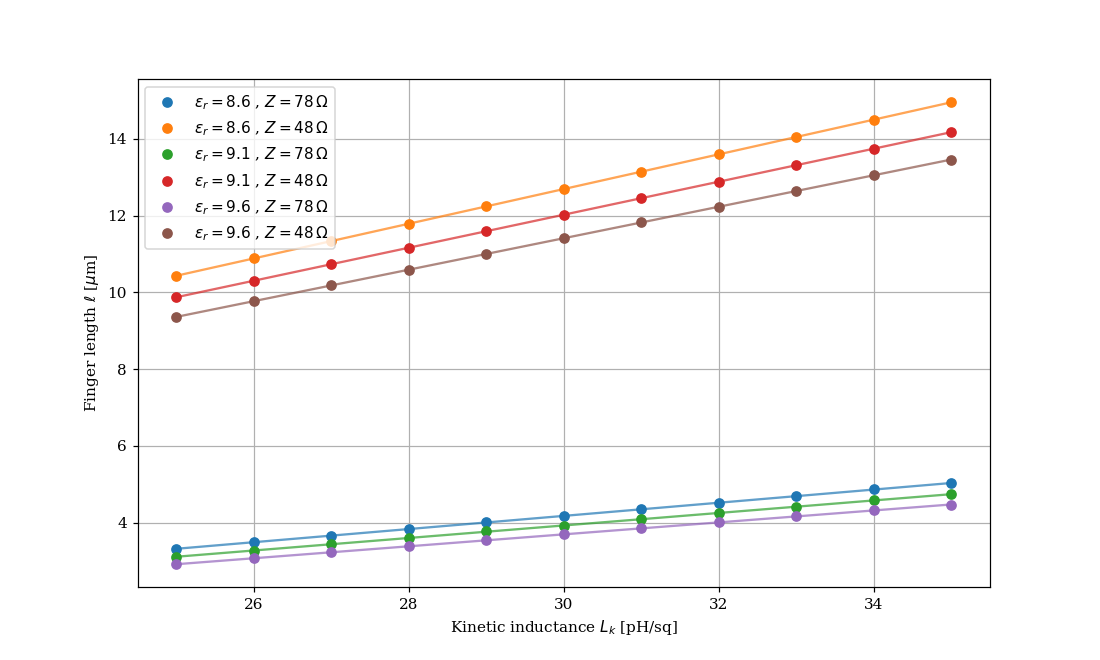

 
0.1715 x - 0.9716
8.6 78 0.17151897007882605 -0.9716062515342424
 
0.4522 x - 0.8725
8.6 48 0.45221249397667046 -0.8724872487248734
 
0.1631 x - 0.9685
9.1 78 0.16309275481192673 -0.9685455851072409
 
0.4303 x - 0.8841
9.1 48 0.4302908751153574 -0.8841022513389648
 
0.1558 x - 0.9809
9.6 78 0.15578921528516487 -0.9809435489003446
 
0.4102 x - 0.894
9.6 48 0.4101946558292195 -0.8940348580312666


In [16]:
fig=plt.figure()

for e in resdict:
    for Z in resdict[e]:
        plt.plot(resdict[e][Z]['Lk'], resdict[e][Z]['l'], marker='o', ls='none',             
                 label='$\\varepsilon_r={eps}$ , $Z={Z}\,\\Omega$'.format(eps=e, Z=Z))
    
        p = np.poly1d(np.polyfit(resdict[e][Z]['Lk'], resdict[e][Z]['l'], 1))
        plt.plot(resdict[e][Z]['Lk'], p(resdict[e][Z]['Lk']),              
                 color=plt.gca().lines[-1].get_color(), alpha=0.7)
        
        resdict[e][Z]['p']=[p.coef[0], p.coef[1]]
        
        print(p)
        print(e, Z, p.coef[0], p.coef[1])
    
plt.ylabel('Finger length $\ell$ [$\\mu$m]')
plt.xlabel('Kinetic inductance $L_k$ [pH/sq]')
plt.legend(loc="upper left")


for e in ['.pdf', '.svg']:
    plt.gcf().savefig(os.path.join(saveplot,'global_trend_ell_vs_Lk'+e),
                      bbox_inches='tight', transparent=True)

<IPython.core.display.Javascript object>


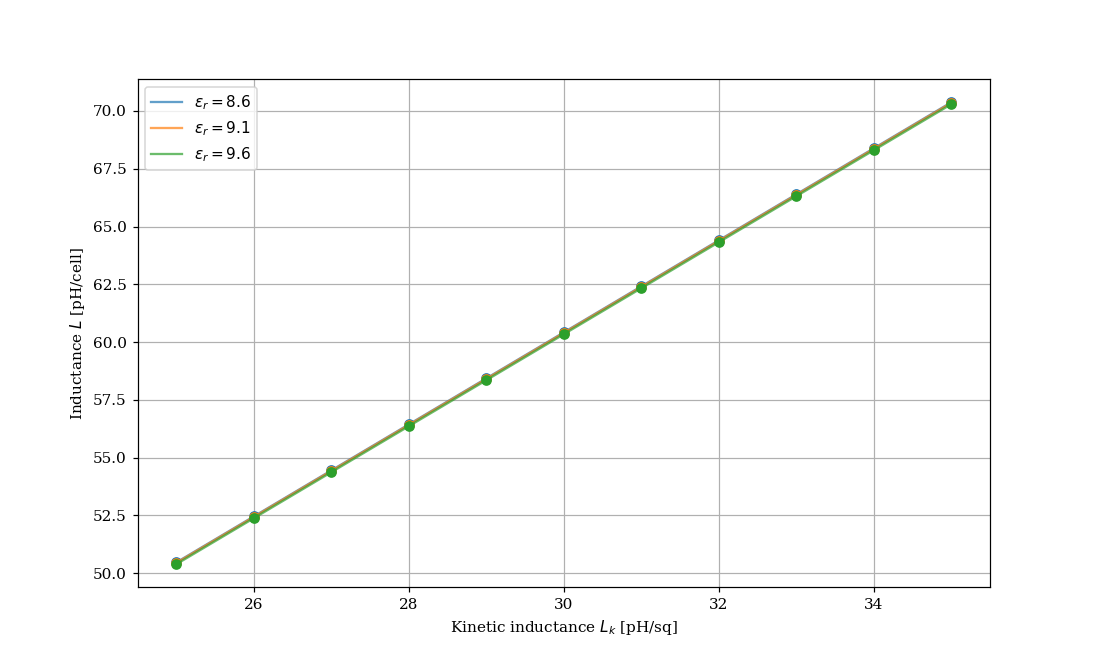

 
1.991e-12 x + 6.74e-13
8.6 1.9914811495184308 0.6739935155921409
 
1.991e-12 x + 6.621e-13
9.1 1.9911680793147695 0.6621151027594027
 
1.991e-12 x + 6.128e-13
9.6 1.9908229842915404 0.6127637219896724


In [17]:
plt.figure()
    
for e in data:
    Lcell=list()
    for Lk in data[e]:
        Lcell.append(np.mean(data[e][Lk]['Lfit']))
    
    Lcell = np.array(Lcell)
    Lkss  = np.array(list(data[e].keys()))  

    plt.plot(Lkss, Lcell*1e12, marker='o', ls='none')

    p = np.poly1d(np.polyfit(Lkss, Lcell, 1))
    plt.plot(Lkss, p(Lkss)*1e12,                 
             color=plt.gca().lines[-1].get_color(), alpha=0.7, 
             label='$\\varepsilon_r={eps}$'.format(eps=e))

    print(p)
    print(e, p.coef[0]*1e12, p.coef[1]*1e12)


plt.xlabel('Kinetic inductance $L_k$ [pH/sq]')
plt.ylabel('Inductance $L$ [pH/cell]')
plt.legend(loc="upper left")


for e in ['.pdf', '.svg']:
    plt.gcf().savefig(os.path.join(saveplot,'global_trend_Lcell_vs_Lk'+e),
                      bbox_inches='tight', transparent=True)

<IPython.core.display.Javascript object>


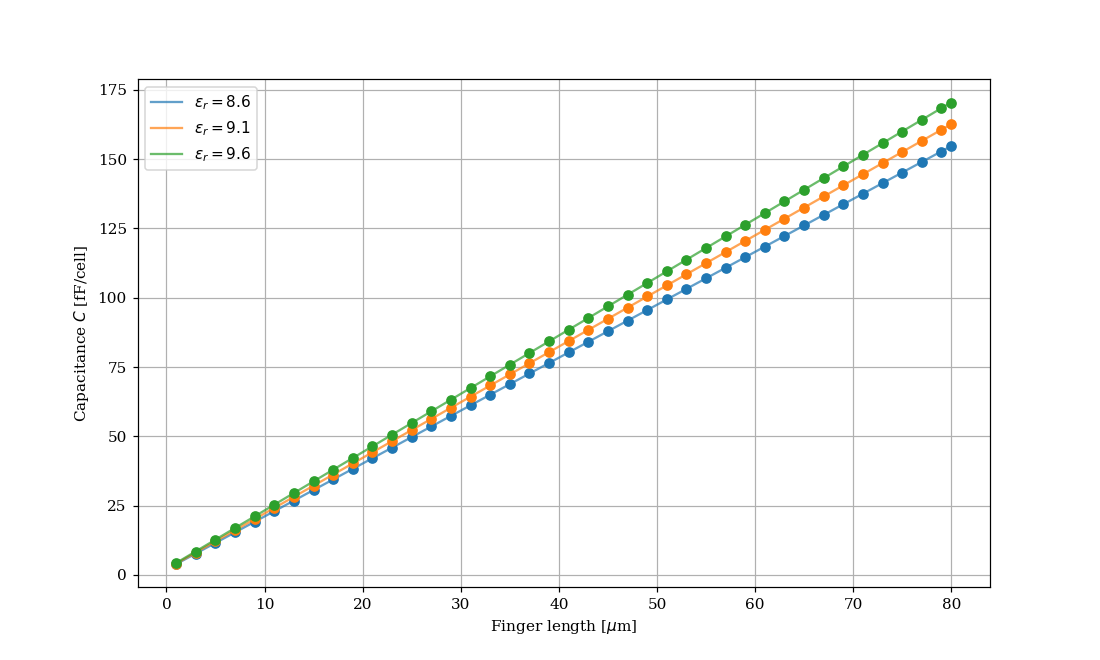

 
1.908e-15 x + 2.025e-15
0.0019083746961098703 0.002024637523572012
 
2.006e-15 x + 2.127e-15
0.002005892778213499 0.002126644721905253
 
2.103e-15 x + 2.23e-15
0.002103101048759458 0.0022298381981747115


In [18]:
plt.figure()

for e in data:
    Lcell=list()
    
    cnt = 0
    
    Cmean=np.array([])
    for Lk in data[e]:
        if Cmean.size:
            Cmean += data[e][Lk]['C']
        else:
            Cmean = data[e][Lk]['C']
            l = data[e][Lk]['l']
        cnt=cnt+1
    
    Cmean /= cnt
    plt.plot(l, Cmean*1e15, marker='o', ls='none')
    
    p = np.poly1d(np.polyfit(l, Cmean, 1))
    plt.plot(l, p(l)*1e15,                 
             color=plt.gca().lines[-1].get_color(), alpha=0.7, 
             label='$\\varepsilon_r={eps}$'.format(eps=e))

    print(p)
    print(p.coef[0]*1e12, p.coef[1]*1e12)
    
plt.legend(loc="upper left") 
plt.xlabel('Finger length [$\\mu$m]')
plt.ylabel('Capacitance $C$ [fF/cell]')



for e in ['.pdf', '.svg']:
    plt.gcf().savefig(os.path.join(saveplot,'global_trend_Ccell_vs_Lk'+e),
                      bbox_inches='tight', transparent=True)
        

## From target Impedance to finger length, Capacitance and Inductance 

In [19]:
Zarget = [78, 48]
w  = 1    # finger width
Lk = 10e-12  # kinetic inductance

for e in eps:
    for Lk in data[e]:
        print('-' * 100)
        print('Lk = {Lk:.2f} pH/sq'.format(Lk=Lk))
        print('-' * 100)
    
        for Z , islabel in zip(Zarget, [True, False]):
            idx=np.argmin(np.abs(Z-data[e][Lk]['Zfit']))
            dump(Z,              
                 data[e][Lk]['Zfit'][idx], 
                 data[e][Lk]['lfit'][idx],              
                 data[e][Lk]['Lfit'][idx],             
                 data[e][Lk]['Cfit'][idx],              
                 w, Lk*1e-12, islabel)

        print('-' * 100)
        print('\n')

----------------------------------------------------------------------------------------------------
Lk = 25.00 pH/sq
----------------------------------------------------------------------------------------------------
Z0target    Z0          l           L           C           Lk          nsq         Lf          Cf          
[Ohm]       [Ohm]       [um]        [pH]        [fF]        [pH/sq]                 nH          [fF]        
--------------------------------------------------------------------------------------------------------------
78.00       78.01       3.31        50.47       8.29        25.00       3.31        0.08        4.15        
48.00       48.00       10.43       50.47       21.91       25.00       10.43       0.26        10.95       
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
Lk = 26.00 pH/sq
-------------

In [20]:
Zarget = [78, 48]
Lks=[25, 30, 35]

w  = 1    # finger width
Lk = 10e-12  # kinetic inductance

for e in eps:
    for Lk in (Lk for Lk in data[e] if Lk in Lks):
        print('-' * 110)
        print('Lk = {Lk:.2f} pH/sq - eps_r = {e}'.format(Lk=Lk,e=e))
        print('-' * 110)
    
        for Z , islabel in zip(Zarget, [True, False]):
            idx=np.argmin(np.abs(Z-data[e][Lk]['Zfit']))
            dump(Z,              
                 data[e][Lk]['Zfit'][idx], 
                 data[e][Lk]['lfit'][idx],              
                 data[e][Lk]['Lfit'][idx],             
                 data[e][Lk]['Cfit'][idx],              
                 w, Lk*1e-12, islabel)

        print('-' * 110)
        print('\n')

--------------------------------------------------------------------------------------------------------------
Lk = 25.00 pH/sq - eps_r = 8.6
--------------------------------------------------------------------------------------------------------------
Z0target    Z0          l           L           C           Lk          nsq         Lf          Cf          
[Ohm]       [Ohm]       [um]        [pH]        [fF]        [pH/sq]                 nH          [fF]        
--------------------------------------------------------------------------------------------------------------
78.00       78.01       3.31        50.47       8.29        25.00       3.31        0.08        4.15        
48.00       48.00       10.43       50.47       21.91       25.00       10.43       0.26        10.95       
--------------------------------------------------------------------------------------------------------------


---------------------------------------------------------------------------------------

## From finger length to Capacitance, Inductance and Impedance 

In [21]:
#(lmin, lmax, lstep) = (2.5, 7, 0.25)
#ltarget = np.linspace(lmin, lmax, int((lmax-lmin)/lstep+1))
ltarget = [3.5, 11]

In [22]:
for e in eps:
    for Lk in data[e]:
    
        print('-' * 100)
        print('Lk = {Lk:.2f} pH/sq'.format(Lk=Lk))
        print('-' * 100)
    
        for l, islabel in zip(ltarget, [True]+[False]*(len(ltarget)-1)):
            idx=np.argmin(np.abs(l-data[e][Lk]['lfit']))
            dump(data[e][Lk]['Zfit'][idx],     
                 data[e][Lk]['Zfit'][idx], 
                 data[e][Lk]['lfit'][idx], 
                 data[e][Lk]['Lfit'][idx],
                 data[e][Lk]['Cfit'][idx], 
                 w, Lk*1e-12, islabel)
        
        print('-' * 100)
        print('\n')

----------------------------------------------------------------------------------------------------
Lk = 25.00 pH/sq
----------------------------------------------------------------------------------------------------
Z0target    Z0          l           L           C           Lk          nsq         Lf          Cf          
[Ohm]       [Ohm]       [um]        [pH]        [fF]        [pH/sq]                 nH          [fF]        
--------------------------------------------------------------------------------------------------------------
76.42       76.42       3.50        50.47       8.64        25.00       3.50        0.09        4.32        
46.85       46.85       11.00       50.47       23.00       25.00       11.00       0.28        11.50       
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
Lk = 26.00 pH/sq
-------------

## Plot for March Meeting Talk

In [23]:
Lk = 30.0
e  = 9.6

basepath = '/home/giachero/gsbox/kids_rd/DARTWARS/sonnet-sim/IMS-NIST/general'
filepath = os.path.join(basepath,'eps{e}_d{d}'.format(e=e, d=d))

filepath = os.path.join(filepath,'sim-results', 'sim_eps{e}_Lk{Lk}'.format(e=e, Lk=Lk), 'savepath')
filename = os.path.join(filepath,'Lk30.0_t10_w1_s1_d100_eps9.6_reduced.h5')

In [24]:
filename

'/home/giachero/gsbox/kids_rd/DARTWARS/sonnet-sim/IMS-NIST/general/eps9.6_d100/sim-results/sim_eps9.6_Lk30.0/savepath/Lk30.0_t10_w1_s1_d100_eps9.6_reduced.h5'

In [25]:
data = file2dic(filename, writer='h5').read() 

ZOfun = lambda L, C : np.sqrt(L/C)
data.update({'Z'   : ZOfun(data['L'],   data['C']),                                                                     
             'Zfit': ZOfun(data['Lfit'],data['Cfit'])})

<IPython.core.display.Javascript object>


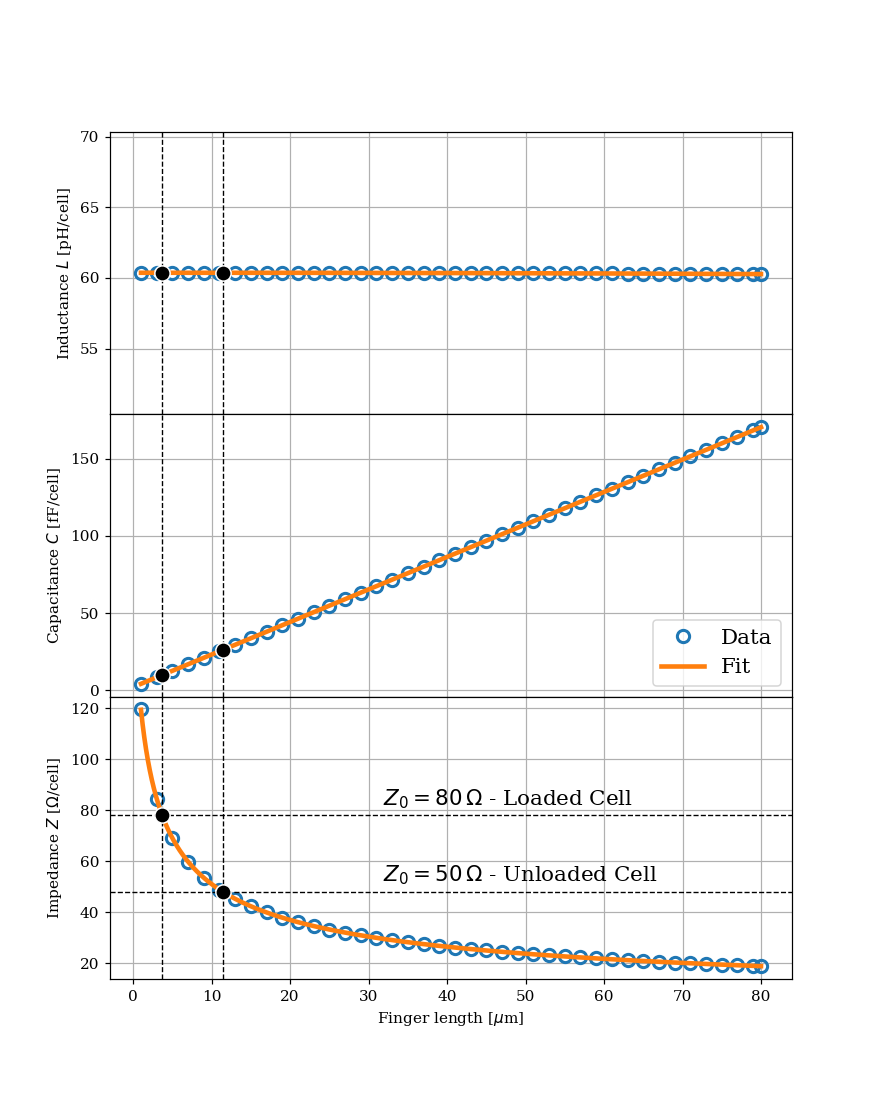

{78: 'Loaded Cell', 48: 'Unloaded Cell'}
[78, 48] 3.694169416941694
[78, 48] 11.413241324132413


In [26]:
fig, ax = plt.subplots(3)

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

import matplotlib 
matplotlib.rc('font', **font)
matplotlib.rc('font', family='serif')


plt.subplots_adjust(wspace=0, hspace=0)
fig.set_size_inches(8, 10, forward=True)

ax[0].plot(data['l'],    data['L']*1e12, marker = 'o', ls='none', 
           mfc='none', markersize=8, markeredgewidth=2)
ax[0].plot(data['lfit'], data['Lfit']*1e12, marker = 'none', ls='-',
           #label='$L_k={Lk}$ pH/sq'.format(Lk=Lk),           
          linewidth=3 
          )

Lmean = np.mean(data['Lfit'])
ax[0].set_ylim([Lmean*1e12-10, Lmean*1e12+10])
ax[0].get_xaxis().set_ticklabels([])
    
#ax[0].set_title('Dieletric Constant $\\varepsilon_r={e}$'.format(e=e))
#ax[0].set_xlabel('Finger length [$\\mu$m]')
ax[0].set_ylabel('Inductance $L$ [pH/cell]')
        #ax[0].legend(loc="lower left")

    
    
ax[1].plot(data['l'],    data['C']*1e15, marker = 'o',ls='none', 
           mfc='none', markersize=8, markeredgewidth=2, label='Data')
ax[1].plot(data['lfit'], data['Cfit']*1e15, marker = 'none', ls='-', 
           label='Fit',                     
           linewidth=3)

ax[1].get_xaxis().set_ticklabels([])

#ax[1].set_xlabel('Finger length [$\\mu$m]')
ax[1].set_ylabel('Capacitance $C$ [fF/cell]')
ax[1].legend(loc="lower right")


ax[2].plot(data['l'],    data['Z'], marker = 'o', ls='none', 
           mfc='none', markersize=8, markeredgewidth=2)
ax[2].plot(data['lfit'], data['Zfit'], marker = 'none', ls='-', 
           #label='$L_k={Lk}$ pH/sq'.format(Lk=Lk),           
          linewidth=3 
          )  



ax[2].set_xlabel('Finger length [$\\mu$m]')
ax[2].set_ylabel('Impedance $Z$ [$\\Omega$/cell]')



Labels = ['Loaded Cell', 'Unloaded Cell']
Zarget = [78, 48]
Zeff   = [80, 50]


desc = dict(zip(Zarget, Labels))
Zeff = dict(zip(Zarget, Zeff))

print(desc) 


for Z0target in Zarget:
    ax[2].axhline(y=Z0target, color='black', lw=0.9, ls='--')
    xtext=plt.gca().get_xlim()[1]-0.60*(plt.gca().get_xlim()[1]-plt.gca().get_xlim()[0])
    ax[2].text(xtext, Z0target+4, r'$Z_0 = {Z}\,\Omega$ - {d}'.format(Z=Zeff[Z0target], d=desc[Z0target]))
       
    idx=np.argmin(np.abs(Z0target-data['Zfit']))
    
    for i in [0,1,2]:        
        ax[i].axvline(x=data['lfit'][idx], color='black', lw=0.9, ls='--')
    
    ax[0].plot(data['lfit'][idx], data['Lfit'][idx]*1e12, marker='o', ls='none', 
               markersize=10, color='black', markeredgecolor='white')
    ax[1].plot(data['lfit'][idx], data['Cfit'][idx]*1e15, marker='o', ls='none', 
               markersize=10, color='black', markeredgecolor='white')
    ax[2].plot(data['lfit'][idx], data['Zfit'][idx],      marker='o', ls='none', 
               markersize=10, color='black', markeredgecolor='white')
    
    print(Zarget, data['lfit'][idx])
    
    
    
#saveplot = os.path.join(str(e),'sim-results', 'sim_eps{e}_Lk{Lk}'.format(e=e, Lk=Lk), 'saveplot')

#print(saveplot)

for e in ['.pdf', '.svg']:
    plt.gcf().savefig(os.path.join(saveplot,'global_trend_MM2024'+e),
                      bbox_inches='tight', transparent=True)

In [27]:
os.listdir(filepath)

['Lk30.0_t10_w1_s1_d100_eps9.6_reduced.h5',
 'Lk30.0_t10_w1_s1_d100_eps9.6.h5',
 'Lk30.0_t10_w1_s1_d100_eps9.6.txt']

In [28]:
# Convert two lists into a Dictionary
Labels  = ['Loaded Cell', 'Unloaded Cell']
Ztarget = [80, 50]

desc = dict(zip(Ztarget, Labels))
print(desc)  

{80: 'Loaded Cell', 50: 'Unloaded Cell'}
